# Microsoft Original Content Insight Project

## Project Goal
My goal is to give Microsoft insight into what type of original content they should create.

## Data Source and Data Exploration

The data comes from ***IMDB*** and ***The Numbers***

The IMDB SQLite database has all of the details about the movie as well as the people in it and who created it.

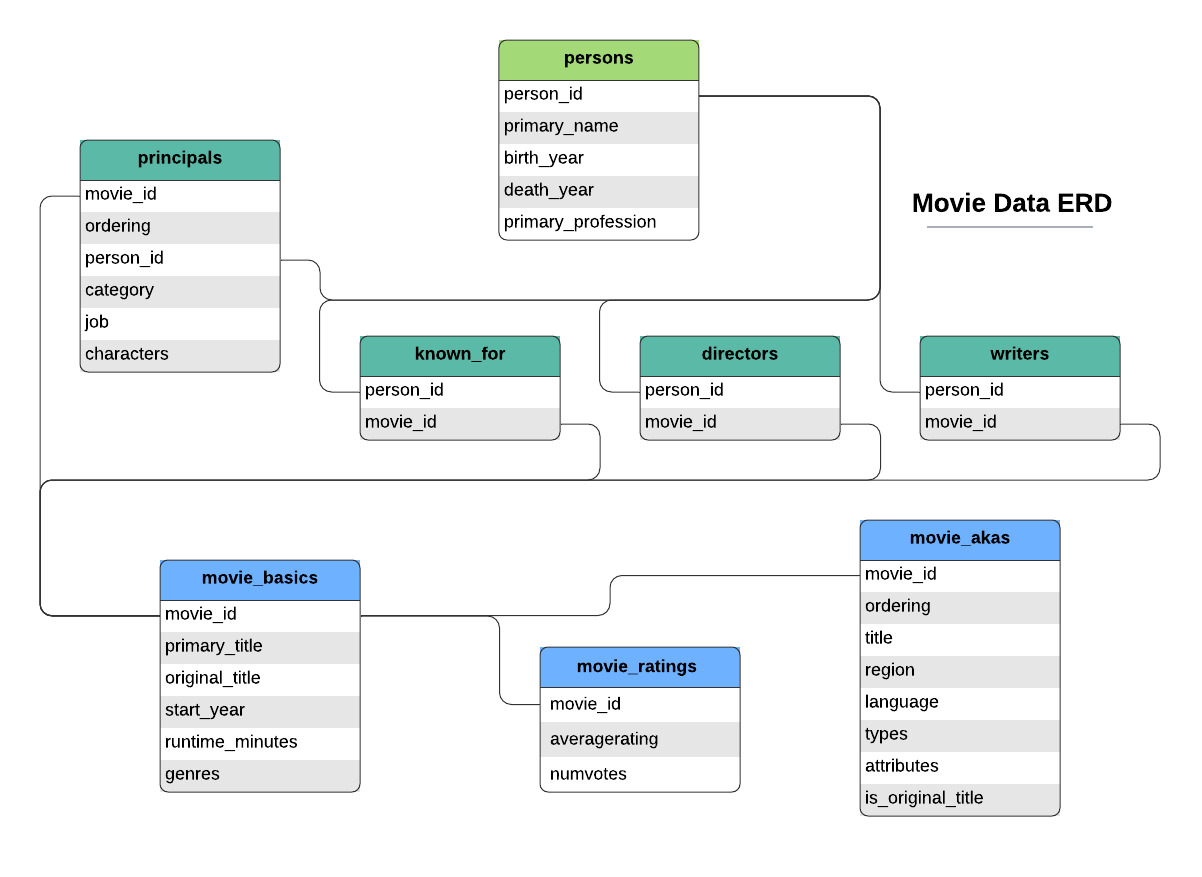

The Numbers has monetary information about the film:
- `production_budget`
- `domestic_gross`
- `worldwide_gross`

### Import all of the modules that will be used in this notebook

In [1]:
import sqlite3
from zipfile import ZipFile
import pandas as pd
import os
import csv
import datetime
import locale
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Connecting and Visualizing _IMDB_ Data

For this project I will be using the the _movie_basics_ table

In [2]:
with ZipFile('Data/im.db.zip', 'r') as zip:
    zip.extractall()

In [3]:
imdb = sqlite3.connect('im.db')

In [4]:
imdb_basics = pd.read_sql("""
SELECT *
  FROM movie_basics;
""", imdb)

imdb_basics #prints a dataframe of the movie_basic data

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [5]:
os.remove('im.db')

## Connecting and Visualizing _The Numbers_ Data

In [6]:
budget_gross = pd.read_csv("data/tn.movie_budgets.csv")

In [7]:
budget_gross['year'] = pd.DatetimeIndex(budget_gross['release_date']).year #Pulled the year out of the release date.

budget_gross #prints a dataframe of The Numbers table

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",1999
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015


### Clean movie titles for merging later

Here I cleaned the movie title data in order to get the most matching data.
Three techniques were used:
- Made all titles lowercase to remove any case sensitivity.
- Removed anything after a '(' to remove a year for a remake or an AKA title.
- Removed any whitespace

In [8]:
budget_gross['movie'] = budget_gross['movie'].str.lower()
imdb_basics['primary_title'] = imdb_basics['primary_title'].str.lower()

In [9]:
budget_gross['movie'] = budget_gross['movie'].str.split('(').str[0]
imdb_basics['primary_title'] = imdb_basics['primary_title'].str.split('(').str[0]

In [10]:
budget_gross['movie'] = budget_gross['movie'].str.strip()
imdb_basics['primary_title'] = imdb_basics['primary_title'].str.strip() 

### IMDB movie data with Budget data. Joined only where movie title and release year match.

Data was joined along the release year in order to remove titles that may have shared similiar titles.

In [11]:
movie_genres_budget = pd.merge(imdb_basics, budget_gross, left_on=['primary_title', 'start_year'], right_on=['movie', 'year'])

len(movie_genres_budget)

1591

### Clean up the production budget and worldwide gross

Removed punctuation in order to use in calculations.

In [12]:
#Remove '$' & ',' from Worldwide Gross convert to an integer
movie_genres_budget['worldwide_gross'] = movie_genres_budget['worldwide_gross'].str.replace('$','')
movie_genres_budget['worldwide_gross'] = movie_genres_budget['worldwide_gross'].str.replace(',','')
movie_genres_budget['worldwide_gross'] = movie_genres_budget['worldwide_gross'].astype(int)
movie_genres_budget = movie_genres_budget[movie_genres_budget['worldwide_gross'] > 0]

#Remove '$' & ',' from Production Budget convert to an integer
movie_genres_budget['production_budget'] = movie_genres_budget['production_budget'].str.replace('$','')
movie_genres_budget['production_budget'] = movie_genres_budget['production_budget'].str.replace(',','')
movie_genres_budget['production_budget'] = movie_genres_budget['production_budget'].astype(int)

### Movie return on investment

Calculate the `Return on Investment` by subtracting production budget from worldwide gross

In [13]:
movie_genres_budget['Return on Investment'] = movie_genres_budget['worldwide_gross'] - movie_genres_budget['production_budget']
genre_budget_cleaned = movie_genres_budget[['genres', 'production_budget', 'worldwide_gross', 'Return on Investment']]
genre_budget_cleaned

,genres,production_budget,worldwide_gross,Return on Investment
0,"Action,Animation,Comedy",45000000,73706,-44926294
1,"Adventure,Comedy,Drama",91000000,187861183,96861183
2,"Action,Crime,Drama",28000000,62108587,34108587
3,"Action,Adventure,Sci-Fi",215000000,1648854864,1433854864
4,"Comedy,Drama",45000000,21544732,-23455268
...,...,...,...,...
1582,"Crime,Drama,Thriller",50000000,170857676,120857676
1583,"Action,Comedy,Crime",1500000,98806,-1401194
1584,"Drama,Horror,Mystery",9000000,64179495,55179495
1588,Documentary,5000000,6653715,1653715


In [14]:
movie_genres_budget['genres'].value_counts()['Adventure,Drama,Sci-Fi']

2

In [15]:
movie_genres_budget['genres'].value_counts()['Action,Adventure,Sci-Fi']

52

In [16]:
movie_genres_budget['genres'].value_counts()['Adventure,Fantasy']

3

In [17]:
movie_genres_budget['genres'].value_counts()['Drama,Family,Fantasy']

1

### Show the top 20 genres, based on return of investment.

In [18]:
genre_grouped = genre_budget_cleaned.groupby(['genres']).mean().astype(int).sort_values(['Return on Investment'], ascending=False)
genre_grouped = genre_grouped.reset_index()
genre_grouped

,genres,production_budget,worldwide_gross,Return on Investment
0,"Family,Fantasy,Musical",160000000,1259199706,1099199706
1,"Fantasy,Musical",200000000,1025491110,825491110
2,"Adventure,Drama,Sci-Fi",136500000,660825409,524325409
3,"Action,Adventure,Sci-Fi",174088461,660635141,486546679
4,"Adventure,Fantasy",231666666,701210693,469544026
...,...,...,...,...
215,"Adventure,Drama,History",46500000,23726626,-22773374
216,"Comedy,Horror,Sci-Fi",33000000,70958,-32929042
217,"Action,Fantasy,Western",42000000,8514325,-33485675
218,"Crime,Drama,History",50000000,8004221,-41995779


In [19]:
for x in genre_grouped.index:
    genre_grouped.at[x,'genre_count'] = genre_budget_cleaned['genres'].value_counts()[genre_grouped.at[x,'genres']]

genre_grouped

,genres,production_budget,worldwide_gross,Return on Investment,genre_count
0,"Family,Fantasy,Musical",160000000,1259199706,1099199706,1.0
1,"Fantasy,Musical",200000000,1025491110,825491110,1.0
2,"Adventure,Drama,Sci-Fi",136500000,660825409,524325409,2.0
3,"Action,Adventure,Sci-Fi",174088461,660635141,486546679,52.0
4,"Adventure,Fantasy",231666666,701210693,469544026,3.0
...,...,...,...,...,...
215,"Adventure,Drama,History",46500000,23726626,-22773374,1.0
216,"Comedy,Horror,Sci-Fi",33000000,70958,-32929042,1.0
217,"Action,Fantasy,Western",42000000,8514325,-33485675,1.0
218,"Crime,Drama,History",50000000,8004221,-41995779,1.0


### Reducing Genre Data

Now that we have the data grouped by genre, we want to reduce this information further.
Below, I removed all of the genres that had less than 5 films.  This is so we can have
a better average across all the films in the genre and not just a genre with two films
and one of them having an extrordinary `Return on Investment`.

In [20]:
genres_over_5_film= genre_grouped[genre_grouped.genre_count >= 5]
genres_over_5_film

,genres,production_budget,worldwide_gross,Return on Investment,genre_count
3,"Action,Adventure,Sci-Fi",174088461,660635141,486546679,52.0
6,"Animation,Comedy,Family",69600000,421415252,351815252,5.0
7,"Action,Adventure,Animation",126125000,468925540,342800540,16.0
10,"Adventure,Animation,Comedy",102905797,403353686,300447889,69.0
11,"Action,Adventure,Comedy",102886363,401934776,299048412,22.0
...,...,...,...,...,...
144,"Drama,Fantasy,Romance",27442857,46920421,19477564,7.0
155,Drama,16679036,32521423,15842387,55.0
166,"Drama,Music",7420000,14924570,7504570,10.0
167,"Crime,Thriller",25285714,32575429,7289715,7.0


#### Resuce the data

We have nearly 200 genre combinations! It also looks like many of those have a negative return on investment.

Let's reduce that to the top 20 highest average return on investment.

In [21]:
top_20_genres = genres_over_5_film.head(10)
top_20_genres = top_20_genres.reset_index()
top_20_genres

,index,genres,production_budget,worldwide_gross,Return on Investment,genre_count
0,3,"Action,Adventure,Sci-Fi",174088461,660635141,486546679,52.0
1,6,"Animation,Comedy,Family",69600000,421415252,351815252,5.0
2,7,"Action,Adventure,Animation",126125000,468925540,342800540,16.0
3,10,"Adventure,Animation,Comedy",102905797,403353686,300447889,69.0
4,11,"Action,Adventure,Comedy",102886363,401934776,299048412,22.0
5,13,"Adventure,Family,Fantasy",140560000,397097638,256537638,15.0
6,15,"Action,Adventure,Fantasy",151425000,402678834,251253834,32.0
7,18,"Action,Adventure,Thriller",115461538,340470420,225008882,13.0
8,24,"Drama,Sci-Fi,Thriller",32100000,221795112,189695112,5.0
9,25,"Action,Sci-Fi,Thriller",46166666,223269393,177102726,9.0


### Plot top 20 genres

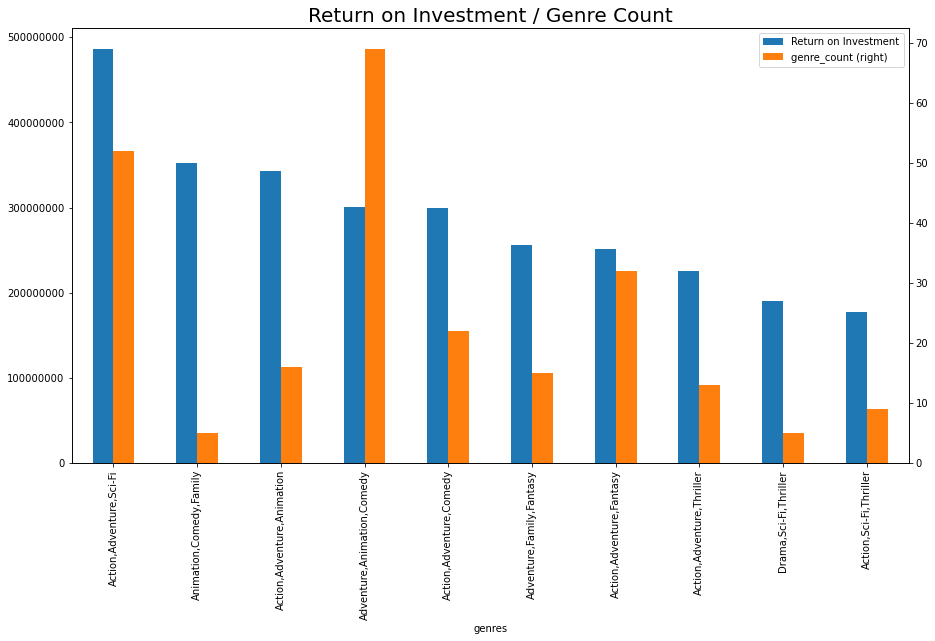

In [22]:
x=top_20_genres['genres']
y1=top_20_genres['Return on Investment']
y2=top_20_genres['genre_count']

top_20_genres.plot(x='genres', y=['Return on Investment','genre_count'],
                   secondary_y='genre_count', stacked=False, kind='bar', figsize=(15,8));
plt.title("Return on Investment / Genre Count", size=20)

plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

## Conclusions

This analysis yields fours movie genres that have the best opportunity for return on investment.

1. Action,Adventure,Sci-Fi
2. Animation,Comedy,Family
3. Action,Adventure,Animation
4. Adventure,Animation,Comedy

My recomendation would be Action,Adventure,Sci-Fi genre. That genre earns an average of over $487 million
and has 52 films in the category.

## Next Steps

Further analyses could yield additional insights to further improve upon these metrics.
- **Directors:** What directors produce the best return on investment inside these genres.
- **Actors:** Are there particular actors that yield a higher profit for these movies.
- **Release date:** Does the movie release date have an affect on profit?